# Práctica Final NLP

# Modelado de Topics

## Carga de Datos

Se ha realizado la descarga de los siguientes ficheros:

* **reviews_Video_Games_5.json.gz** -> Fichero con reviews de video games
* **reviews_Automotive_5.json.gz** -> Fichero con reviews de automoción
* **reviews_Beauty_5.json** -> Fichero con reviews de belleza
* **reviews_Digital_Music_5.json.gz** -> Fichero con reviews de musica

In [327]:
import os

path = os.getcwd()
path

'C:\\Users\\josu.lazaro\\Desktop\\BOOTCAMP Big Data&Machine Learning\\Bootcamp\\13.-NLP Searching\\Practica\\Datos Tweets'

In [328]:
#Accedemos a la ruta donde se han descargado los datos descargados
path = os.chdir('C:\\Users\\josu.lazaro\\Desktop\\BOOTCAMP Big Data&Machine Learning\\Bootcamp\\13.-NLP Searching\\Practica\\Data_Reviews')

In [329]:
#Realizamos sample de 2000 reviews de cada uno de los ficheros y lo almacenamos en un dataFrame correspondiente.
#Nos quedamos con la columna "reviewText" que es la columna que nos aporta la información que necesitamos para el análisis
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_reviews_video_games = getDF('reviews_Video_Games_5.json.gz').sample(2000,random_state=1)[['reviewText']]
df_reviews_Automotive = getDF('reviews_Automotive_5.json.gz').sample(2000,random_state=1)[['reviewText']]
df_reviews_Beauty = getDF('reviews_Beauty_5.json.gz').sample(2000,random_state=1)[['reviewText']]
df_reviews_DigitalMusic = getDF('reviews_Digital_Music_5.json.gz').sample(2000,random_state=1)[['reviewText']]


In [330]:
prueba = getDF('reviews_Video_Games_5.json.gz').sample(2000,random_state=1)

In [331]:
prueba.overall.value_counts()

5.0    1033
4.0     494
3.0     229
1.0     127
2.0     117
Name: overall, dtype: int64

In [332]:
df_reviews_video_games.shape

(2000, 1)

In [333]:
df_reviews_Automotive.shape

(2000, 1)

In [334]:
df_reviews_Beauty.shape

(2000, 1)

In [335]:
df_reviews_DigitalMusic.shape

(2000, 1)

Vamos a juntar todos los dataframes en uno y comenzamos a preprocesar

In [15]:
DF_Reviews=pd.concat([df_reviews_video_games,df_reviews_Automotive,df_reviews_Beauty,df_reviews_DigitalMusic],axis=0,ignore_index=True)

In [16]:
DF_Reviews.shape

(8000, 1)

In [17]:
DF_Reviews.head()

reviewText
0  It's something that happens very often in the ...
1  bought this to mount the kinect on top of my V...
2  My, how times change.  Just twenty years ago t...
3  The first thing I noticed as Samus steps of th...
4  GTA is the best game of all time. Absolutely l...

In [52]:
#REalizamos un shuffle para que los reviews esten desordenados
from sklearn.utils import shuffle
DF_Reviews = shuffle(DF_Reviews)
DF_Reviews.head()

reviewText
4727  The oil is great, similar  toProfectiv Growth ...
4682  I will agree with other reviews that this is n...
72    This fits very well in the hand and i love the...
4810  I received this product through the Vine progr...
4935  After getting the chance to give this shampoo ...

## Preprocesado de datos

In [53]:
#Exploramos para ver si tiene algun tipo de na, en cuyo caso los eliminariamos

In [19]:
#Verificamos si existen nas. Observamos que no hay ninguno
DF_Reviews.isna().sum()

reviewText    0
dtype: int64

In [20]:
#Realizamos una pequeña visualización de 3 reviews, para ver el contenido que tiene y la variedad de tokens

In [21]:
for index,text in enumerate(DF_Reviews['reviewText'][35:38]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 have very good sound and are very comfortable, I like a lot of truth, they are very very great, thanks for your services.
Review 2:
 My son saw me playing this game on my PC, then later on my iPod Touch, and finally talked me into getting it for him when he found out it was on Nintendo DS.  This version has a couple of fun play modes that aren't in the other versions I have.  What he enjoys most is playing against his brother or friends in DS download mode, so one of them is plants and the other is zombies.  For those of you who have never seen the game, there isn't any blood or actual gross-out eating of body parts, primarily because it's Plants vs., not people vs.  But it's cartoony and about as tame as you can make zombies get.  I wouldn't recommend it for any kid under 6, both because of the subjects being zombies, but also because it takes a little more advanced thinking to get through the game.  Most kids 6 and up who play lots of games should be able to figure it out 

En estos próximos pasos se va a realizar una pequeña limpieza de datos. Para ello, creamos varias columnas nuevas en el propio dataframe, y así podemos comparar con el original, y finalmente decidiremos con cual de ellas  nos quedamos para realizar el topic modelling y analisis exploratorio.
Los pasos a realizar van a ser:
    * Eliminar las abreviaturas
    * Pasar todo a minuscula
    * Eliminar digitros y palabras que contengan digitos
    * Eliminar signos de puntuación

### Eliminar abreviaturas 

In [22]:
#Buceando por internet, se ha encontrado un artículo donde realiza esta operación, para ello el diccionario que utiliza se encuentra en el siguiente código

import re
#Expand contractions
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
DF_Reviews['reviewText']=DF_Reviews['reviewText'].apply(lambda x:expand_contractions(x))

### Convierte todos los caracteres a minúscula

In [24]:
DF_Reviews['cleaned']=DF_Reviews['reviewText'].apply(lambda x: x.lower())

### Elimina digitos y palabras que contienen digitos

In [59]:
DF_Reviews['cleaned']=DF_Reviews['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

### Elimina simbolos de puntuación

In [26]:
import string
DF_Reviews['cleaned']=DF_Reviews['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [27]:
##Here, string.punctuations function contains all the punctuations and we use regular expressions to search them in the text and remove them. Finally, we still have some extra spaces present in the data. Let’s remove them:
# Removing extra spaces
DF_Reviews['cleaned']=DF_Reviews['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [68]:
##Vemos cómo ha quedado el texto despues de la limpieza

for index,text in enumerate(DF_Reviews['cleaned'][37:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 okay so many buyers said frownies were betternot for me for me frownies did not work at all they did not stick and they were not comfortable at all but dermagen works amazing they just feel like tape when you sleep in them and when i wake up i literally cannot see lines and wrinkles i had the night before this stuff seriously works i keep buying from them they are awesome and i reuse mine normally up to three times a piece i just do not wear night cream with them because they do not stick as well but after using these every night i do not need night cream anymore 
Review 2:
 one excellent game and a nice product worth every penny and i most definitely needed it for my son a purchase that you couldnt get a better price excellent product and a recommended buy
Review 3:
 could not get them to work well for me so i gave them away the person i gave them to love them


### Lematización del texto
Se va a crear una columna con los textos lemmatizados para un posterior análisis

In [28]:
#Vamos a lematizar, creamos otra columna en el dataframe, y analizamos tb esta columna, quizás con menos palabras aporta mas valor
# Importing spacy
import spacy
import es_core_news_sm
import en_core_web_sm

# Loading model
nlp = spacy.load('en',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
DF_Reviews['lemmatized']=DF_Reviews['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [29]:
#Importamos todas las librerias necesarias para el procesado posterior
import random
import pandas as pd

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


Se crea una función para realizar un split de texto a palabras y se limita a un mínimo de 3 caracteres. El resultado será una lista con la que
se podrá realizar el análisis exploratorio y validar el dataset que será el corpus para realizar el topic modelling

In [31]:
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [32]:
DF_Reviews.head()

reviewText  \
0  It is something that happens very often in the...   
1  bought this to mount the kinect on top of my V...   
2  My, how times change.  Just twenty years ago t...   
3  The first thing I noticed as Samus steps of th...   
4  GTA is the best game of all time. Absolutely l...   

                                             cleaned  \
0  it is something that happens very often in the...   
1  bought this to mount the kinect on top of my v...   
2  my how times change just twenty years ago the ...   
3  the first thing i noticed as samus steps of th...   
4  gta is the best game of all time absolutely lo...   

                                          lemmatized  
0  happen rpg world sequels chrono trigger zelda ...  
1  buy mount kinect visio 42 inch tvwork great fi...  
2  time change year ago epitome video entertainme...  
3  thing notice samus step platform time m date g...  
4  gta good game time absolutely love game addict...

A continuación podemos observar cómo la función convierte de texto a palabras con las que podremos realizar el análisis

In [35]:
print('Original text:\n{}\n\n'.format(DF_Reviews['cleaned'][0]))
print('Processed text:\n{}'.format(text_preprocessing(DF_Reviews['lemmatized'][0])))

Original text:
it is something that happens very often in the rpg world sequels chrono trigger zelda xenogearsprequels actually and star ocean all have sequels final fantasy is a different kind of sequel no characters repeat new worlds new storyline and only 4 things usually repeat cid mooglesor mog chocobosostrichlike birds and biggs and wedge however to this day no sequel has been madeuntil nowstory takes place 2 years after final fantasy x yuna has successfully defeated sin a destructive force forever something no one has been able to do however that game is main character tidus goes away 2 years later yuna is part of the gullwings a sphere hunter group who roams the land looking for spheres detailing certain events in spirathe world she receives a sphere which looks like tidus imprisoned and is determined to find out the truthgraphics this one is on 2 fronts world and fmvcutscenes the worlds pretty much the same as ffx same layout and everything but the fmv is whoa especially yunat

Creamos una lista de palabras

In [37]:
lista_palabras = []
for text in DF_Reviews['lemmatized']:
    lista_palabras.append(text_preprocessing(text))

Convertimos lista_palabras(lista de listas) a formato lista para poder ser analizada:

In [39]:
lista_def = []
for sublist in lista_palabras:
    for item in sublist:
        lista_def.append(item)

## Visualización de la información - Análisis Exploratorio

### Frecuencia de palabras

In [40]:
#Importamos la librería Counter para realizar el conteo de los tokens
from collections import Counter
import matplotlib.pyplot as plt

In [42]:
#Realizamos el conteo de cada token
wf = Counter(lista_def)

In [45]:
#Visualizamos los 10 tokens que más aparecen en todo el dataframe
wf_most_common = wf.most_common(10)
wf_most_common

[('game', 8357),
 ('like', 5647),
 ('good', 5085),
 ('album', 4546),
 ('song', 3874),
 ('great', 3691),
 ('time', 3301),
 ('play', 2940),
 ('work', 2553),
 ('love', 2376)]

Visualizamos en formato diagrama de barras las palabras más mencionadas:

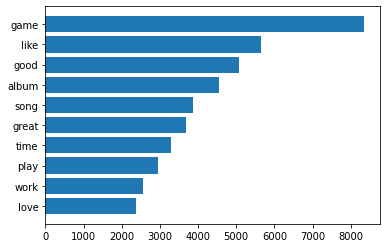

In [46]:
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]

freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

Se puede observar que claramente la palabra game es la más mencionada, tiene total relación con el data de juegos. También las palabras like, album y song pueden tener relación con la musica

### Relaciones de palabras, n-gramas

Una vez realizado el análisis de las palabras de manera independiente, vamos a analizar la relación de varias de ellas mediante n-gramas. En este caso, analizaremos de 2,3 y hasta 4 palabras

In [47]:
# Importamos las librerias necesarías para realizar los conteos de n-gramas
from nltk import ngrams
from nltk.probability import FreqDist

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [52]:
bigrams_ = list(ngrams(lista_def, 2))
trigrams_ = list(ngrams(lista_def, 3))
cuatrigrams_ = list(ngrams(lista_def, 4))

Visualizamos pequeñas muestras de cada uno de ellos:

In [53]:
bigrams_[:5]

[('happen', 'world'),
 ('world', 'sequels'),
 ('sequels', 'chrono'),
 ('chrono', 'trigger'),
 ('trigger', 'zelda')]

In [54]:
trigrams_[:5]

[('happen', 'world', 'sequels'),
 ('world', 'sequels', 'chrono'),
 ('sequels', 'chrono', 'trigger'),
 ('chrono', 'trigger', 'zelda'),
 ('trigger', 'zelda', 'actually')]

In [55]:
cuatrigrams_[:5]

[('happen', 'world', 'sequels', 'chrono'),
 ('world', 'sequels', 'chrono', 'trigger'),
 ('sequels', 'chrono', 'trigger', 'zelda'),
 ('chrono', 'trigger', 'zelda', 'actually'),
 ('trigger', 'zelda', 'actually', 'star')]

Realizamos el conteo de frecuencias de cada uno de ellos:

In [56]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)
cg_freq = FreqDist(cuatrigrams_)

Visualizamos los 5 más frecuentes de cada una de las relaciones:

In [57]:
bg_freq.most_common(5)

[(('game', 'play'), 384),
 (('play', 'game'), 344),
 (('feel', 'like'), 337),
 (('sound', 'like'), 269),
 (('work', 'great'), 267)]

In [58]:
tg_freq.most_common(5)

[(('metal', 'gear', 'solid'), 44),
 (('good', 'song', 'album'), 34),
 (('highly', 'recommend', 'product'), 29),
 (('game', 'play', 'game'), 27),
 (('good', 'game', 'play'), 27)]

In [59]:
cg_freq.most_common(5)

[(('leave', 'skin', 'feel', 'clean'), 7),
 (('game', 'good', 'game', 'play'), 6),
 (('game', 'play', 'long', 'time'), 5),
 (('clear', 'advantage', 'beam', 'wiper'), 5),
 (('advantage', 'beam', 'wiper', 'blade'), 5)]

Vamos a calcular los diagramas de barras para poder ser visualizados

In [60]:
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

cg_freq_most_common = cg_freq.most_common(10)
cgs_ = [str(cg[0]) for cg in cg_freq_most_common]
cgs_f_ = [cg[1] for cg in cg_freq_most_common]

In [61]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))
cgs_f_, cgs_ = zip(*sorted(zip(cgs_f_, cgs_)))

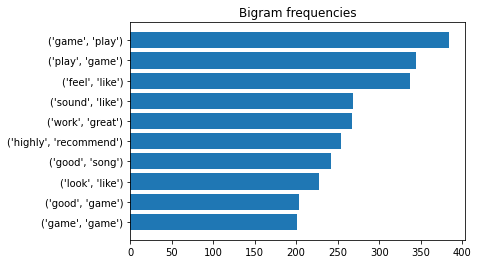

In [62]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

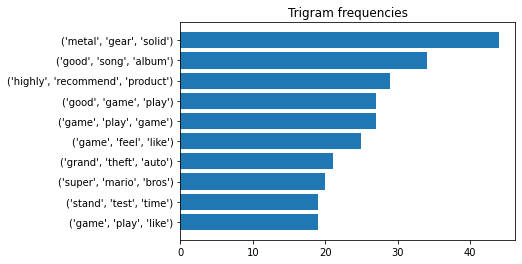

In [63]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

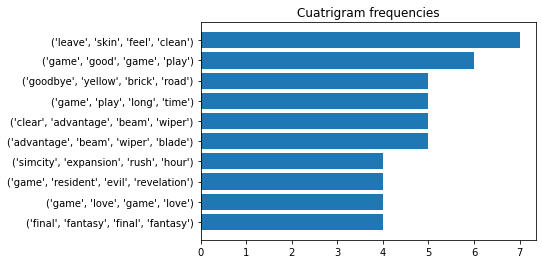

In [64]:
plt.barh(cgs_, cgs_f_)
plt.title('Cuatrigram frequencies')
plt.show()

### Word cloud

Mediante una nube de palabras podemos ver las palabras más comunes de una manera más clara aún.

In [65]:
#Importamos las librerías necesarias
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [66]:
print(len(lista_def))

425668


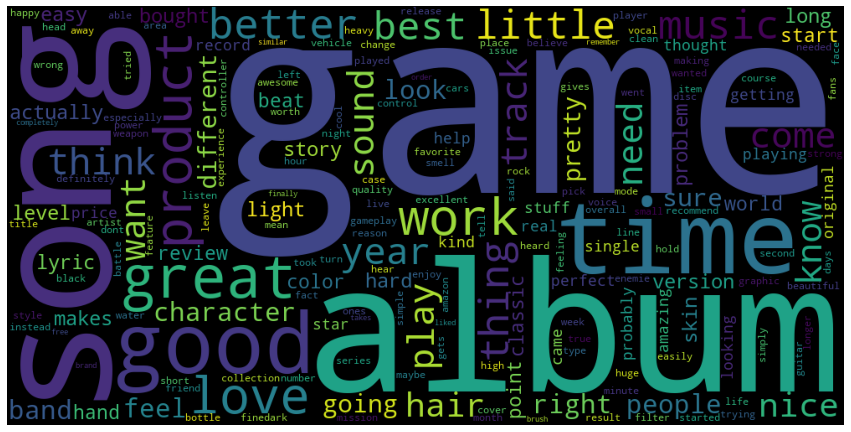

In [187]:
import matplotlib.pyplot as plt

#convert list to string and generate
unique_string=(" ").join(lista_def)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

## Desarrollo Topic modelling

### Diccionario id - palabra

In [67]:
#Creamos diccionario con la lista de palabras creada y analizada en el punto anterior
dictionary = Dictionary(lista_palabras)

In [68]:
list(dictionary.items())

[(0, 'able'),
 (1, 'abundant'),
 (2, 'actually'),
 (3, 'additionally'),
 (4, 'anymore'),
 (5, 'ashe'),
 (6, 'away'),
 (7, 'battle'),
 (8, 'beautiful'),
 (9, 'biggs'),
 (10, 'bird'),
 (11, 'black'),
 (12, 'bored'),
 (13, 'boring'),
 (14, 'certain'),
 (15, 'change'),
 (16, 'character'),
 (17, 'chrono'),
 (18, 'class'),
 (19, 'climb'),
 (20, 'come'),
 (21, 'continuation'),
 (22, 'cumbersomeit'),
 (23, 'cure'),
 (24, 'deal'),
 (25, 'defeat'),
 (26, 'destructive'),
 (27, 'determined'),
 (28, 'different'),
 (29, 'dressphere'),
 (30, 'dull'),
 (31, 'enix'),
 (32, 'especially'),
 (33, 'event'),
 (34, 'everpopular'),
 (35, 'fanfare'),
 (36, 'fantasy'),
 (37, 'feature'),
 (38, 'final'),
 (39, 'fmvcutscene'),
 (40, 'force'),
 (41, 'forever'),
 (42, 'game'),
 (43, 'gang'),
 (44, 'goodbye'),
 (45, 'gorgeous'),
 (46, 'great'),
 (47, 'grid'),
 (48, 'group'),
 (49, 'gullwing'),
 (50, 'happen'),
 (51, 'hello'),
 (52, 'hope'),
 (53, 'hunter'),
 (54, 'imprison'),
 (55, 'introduction'),
 (56, 'jump'),
 (5

In [70]:
# El tamaño del diccionario es de 40629 palabras
len(dictionary)

40629

### Matriz documento-palabra

In [71]:
#Creamos el corpus, con los datos del diccionario, lo vamos a necesitar para el modelo LDA
corpus = [dictionary.doc2bow(doc) for doc in lista_palabras]

In [72]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 2),
 (16, 3),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 2),
 (34, 1),
 (35, 1),
 (36, 3),
 (37, 1),
 (38, 3),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 2),
 (57, 1),
 (58, 1),
 (59, 2),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 2),
 (64, 4),
 (65, 1),
 (66, 1),
 (67, 2),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 2),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 2),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 4),
 (98, 1),
 (99, 1),
 (100, 1),

## Entrenamos el modelo (LDA)

A lo largo de este apartado vamos a aplicar el modelo LDA al texto y diccionario que hemos creado para poder analizar los diferentes topics que se generan y las temáticas que siguen o hacen referencia las reviews:

In [74]:
#Creamos el modelo y le damos 10 cómo número de topics. Más adelante veremos el número óptimo
num_topics = 10

modelo_LDA = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [75]:
#Mostramos una muestra de los resultados de las probabilidades de cada token
modelo_LDA.show_topics()

[(0,
  '0.044*"product" + 0.022*"face" + 0.019*"skin" + 0.013*"apply" + 0.013*"cream" + 0.012*"water" + 0.011*"bottle" + 0.008*"help" + 0.008*"good" + 0.008*"wash"'),
 (1,
  '0.071*"like" + 0.058*"love" + 0.023*"great" + 0.019*"think" + 0.018*"good" + 0.011*"look" + 0.011*"know" + 0.011*"stuff" + 0.010*"feel" + 0.008*"people"'),
 (2,
  '0.042*"album" + 0.036*"song" + 0.014*"track" + 0.013*"good" + 0.012*"music" + 0.012*"sound" + 0.009*"great" + 0.008*"like" + 0.008*"band" + 0.007*"time"'),
 (3,
  '0.023*"nail" + 0.011*"butter" + 0.007*"money" + 0.007*"shea" + 0.006*"mary" + 0.006*"thumb" + 0.005*"mouse" + 0.004*"keyboard" + 0.004*"matte" + 0.004*"simcity"'),
 (4,
  '0.019*"work" + 0.013*"need" + 0.011*"easy" + 0.011*"great" + 0.010*"come" + 0.009*"good" + 0.009*"price" + 0.009*"like" + 0.008*"time" + 0.007*"quality"'),
 (5,
  '0.044*"brush" + 0.018*"makeup" + 0.010*"foundation" + 0.009*"mascara" + 0.009*"shadow" + 0.008*"mirror" + 0.008*"roller" + 0.006*"blush" + 0.005*"bristle" + 0.00

In [77]:
#Vamos a mostrar las palabras de cada topic más comunes
word_dict = {};
for i in range(num_topics):
    words = modelo_LDA.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic #01  Topic #02 Topic #03 Topic #04 Topic #05   Topic #06  \
0      product       like     album      nail      work       brush   
1         face       love      song    butter      need      makeup   
2         skin      great     track     money      easy  foundation   
3        apply      think      good      shea     great     mascara   
4        cream       good     music      mary      come      shadow   
5        water       look     sound     thumb      good      mirror   
6       bottle       know     great     mouse     price      roller   
7         help      stuff      like  keyboard      like       blush   
8         good       feel      band     matte      time     bristle   
9         wash     people      time   simcity   quality        area   
10        soap    amazing    listen      file      look       honey   
11        wear       time      hear     photo  purchase       super   
12       scent       come    record    cotton     small       clean   
13       leave       line   release     image   battery        good   
14        like  beautiful     lyric   whisper    little      gentle   
15  ingredient       want      rock      twin      long        cute   
16       serum    believe      come     stamp      nice        mitt   
17       shine       hard     vocal     drink     thing      animal   
18        line   favorite    guitar      nick     order        chip   
19       paint      thank   classic     trash     cheap       stiff   

    Topic #07   Topic #08  Topic #09 Topic #10  
0        good       blade       game      hair  
1        beat       wheel       play   product  
2   recommend       wiper       time      skin  
3      highly        curl       like      work  
4        know        jack       good     color  
5        year        work  character     smell  
6        nice        plug      story      look  
7        come        burn      thing      feel  
8       great      tender      level     great  
9       metal      engine    graphic     light  
10       like       spark     player     clean  
11     pretty  windshield      great      good  
12      tight        inch       want      like  
13      snoop       plate       look      time  
14      solid        high       feel   shampoo  
15       real   advertise    control    little  
16      crazy       light      enemy      long  
17       time     workout     pretty     leave  
18  christmas        rain       mode      soft  
19      young    exercise      point      wash

### Perplexity y Coherence

A través de estos indicadores podemos ver cómo de bueno es el modelo que hemos creado. Cuanto menor perplexity mejor modelo

In [81]:
# Perplexity
print('\nPerplexity: ', modelo_LDA.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=modelo_LDA, texts=lista_palabras, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.849851024514832

Coherence Score:  0.4338945756558177


A continuación visualizamos los diferentes topics y las relaciones que tienen entre ellos.

Esta clusterización de topics se realiza mediante PCA. Podemos ver cómo estan diferenciados claramente.

    * El topic6 y topic4 hace claramente relación con la belleza.
    * El 5,2 y 1 están muy relacionados y se refieren a juegos y música
    * Los tokens de los clusters 1 y 2 que hacen referencia a musica y juegos, se encuentran principalmente en estos clusters y no aparecen practicamente en ningún otro. Luego tenemos los clusters 8,9 y 10 que están muy alejados de todos y no representan ninguna temática en concreto
   

In [82]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(modelo_LDA, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.233219 -0.131199       1        1  29.051144
8     -0.161394 -0.031834       2        1  26.653042
4     -0.054314  0.122355       3        1  13.393918
9     -0.023630  0.226835       4        1   9.892247
1     -0.131646 -0.001241       5        1   8.555933
0      0.077547  0.150976       6        1   4.154078
6     -0.030534 -0.129439       7        1   3.337002
7      0.166319 -0.030884       8        1   2.237051
5      0.194193 -0.045601       9        1   1.519791
3      0.196679 -0.129967      10        1   1.205789, topic_info=         Term         Freq        Total Category  logprob  loglift
42       game  7547.000000  7547.000000  Default  30.0000  30.0000
15454   album  5254.000000  5254.000000  Default  29.0000  29.0000
242      good  5043.000000  5043.000000  Default  28.0000  28.0000
356      song  4399.000000  4399.000000  Default  27.0000  27.0000
63       like  5817.000000  5817.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2905     sale    13.849701    69.669052  Topic10  -5.9151   2.8025
396    answer    13.446088    62.555267  Topic10  -5.9447   2.8807
1022   filler    13.007954    68.102417  Topic10  -5.9778   2.7626
1424    count    12.560905    51.727261  Topic10  -6.0128   3.0026
2969    waste    12.725095   136.094238  Topic10  -5.9998   2.0483

[678 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
13063      5  0.974009   accent
22137     10  0.895169  acetone
22206      4  0.403487     acne
22206      5  0.009170     acne
22206      6  0.577720     acne
...      ...       ...      ...
788        5  0.283858    young
788        6  0.017741    young
788        7  0.202249    young
14561      5  0.966239    youth
14561      7  0.026840    youth

[1717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 5, 10, 2, 1, 7, 8, 6, 4])

### Número óptimo de topics

In [83]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [116]:
#Grid sobre el número de topics (puede tardar un buen rato)
start_ = 4
end_ = 25
step_ = 1

In [117]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=lista_palabras,
    start=start_,
    limit=end_,
    step=step_
)

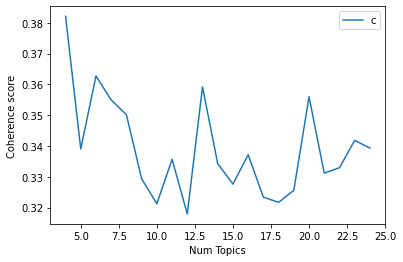

In [118]:
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [119]:
#Seleccionamos el modelo más optimo, 5 topics con coherencia más alta. Corresponde al modelo ejecutado numero 2 segun valores que hemos puesto arriba
optimal_model_id = 2
optimal_model = model_list[optimal_model_id]

# Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=lista_palabras, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.649692423461133

Coherence Score:  0.36271222498494415


In [110]:
optimal_model_id = 2

In [111]:
optimal_model = model_list[optimal_model_id]

word_dict = {};
for i in range(5):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic #01 Topic #02 Topic #03  Topic #04 Topic #05
0       soft      song      good    product     album
1       curl     album      like       hair      song
2       hair     track      song       work      like
3       like      like     great       skin      good
4       funk      love     sound       good     great
5       soap     music     music      great      love
6       good    record      time       look      time
7       game     sound     track       like     track
8       skin      good      game      smell      hear
9       easy     vocal      band      apply     music
10     great      time      work       feel      come
11    jacket      play      love       love     think
12      time      game      come       come      year
13      feel      know     think  recommend     cover
14      wash   release    listen       time     sound
15      hard     debut      feel      color      game
16     album      jazz      rock       easy    artist
17  southern  favorite      want       nice      know
18     leave      come     thing      light    listen
19      need     world      know       nail    little

### Topic dominante por texto

In [112]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [113]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lista_palabras)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             5.0              0.5853   
1            1             3.0              0.9043   
2            2             2.0              0.4193   
3            3             2.0              0.7996   
4            4             2.0              0.9400   
5            5             4.0              0.9396   
6            6             3.0              0.4995   
7            7             2.0              0.9833   
8            8             5.0              0.9650   
9            9             2.0              0.9598   

                                            Keywords  \
0  like, time, good, product, hair, great, love, ...   
1  product, hair, work, skin, good, great, look, ...   
2  good, like, song, great, sound, music, time, t...   
3  good, like, song, great, sound, music, time, t...   
4  good, like, song, great, sound, music, time, t...   
5  album, song, like, good, great, love, time, tr...   
6  product, hair, work, skin, good, great, look, ...   
7  good, like, song, great, sound, music, time, t...   
8  like, time, good, product, hair, great, love, ...   
9  good, like, song, great, sound, music, time, t...   

                                                Text  
0  [happen, world, sequels, chrono, trigger, zeld...  
1  [mount, kinect, visio, inch, tvwork, great, sn...  
2  [time, change, year, epitome, video, entertain...  
3  [thing, notice, samus, step, platform, time, d...  
4  [good, game, time, absolutely, love, game, add...  
5  [super, cheap, considering, awesome, game, ins...  
6  [look, headset, digitaly, opticaly, jack, head...  
7  [good, platformer, dsthis, crappi, looking, or...  
8  [tell, controller, meet, sony, dualshock, stan...  
9  [game, outstanding, tactical, real, feel, like...

### Documento más representativo por topic

In [114]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9569   
1        1.0              0.9964   
2        2.0              0.9987   
3        3.0              0.9972   
4        4.0              0.9910   
5        5.0              0.9960   

                                            Keywords  \
0  soft, curl, hair, like, funk, soap, good, game...   
1  song, album, track, like, love, music, record,...   
2  good, like, song, great, sound, music, time, t...   
3  product, hair, work, skin, good, great, look, ...   
4  album, song, like, good, great, love, time, tr...   
5  like, time, good, product, hair, great, love, ...   

                                                Text  
0  [diferenca, parte, este, juego, dificil, termi...  
1  [look, forward, album, hear, single, quotchop,...  
2  [hesitant, write, review, fanboy, impossible, ...  
3  [hunt, suitable, remote, charger, itit, perfec...  
4  [game, insanely, think, football, game, equal,...  
5  [good, thingstough, standard, keyboard, metal,...

### Distribución de topics en el corpus

In [115]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

topic  contribution
0    3.0      0.421750
1    2.0      0.279375
2    1.0      0.120875
3    4.0      0.095625
4    5.0      0.069750
5    0.0      0.012625

# Analisis Sentimiento

## Carga y tratamiento datos

En primer lugar, vamos a cargar los datos. Los mismos ficheros que hemos utilizado para Topic Modelling. La diferencia es que tenemos que balancear los datos para que haya una distribución homogenea por cada rating.

Posteriormente, vamos a realizar el mismo tratamiento que en el apartado anterior, para la limpieza de los datos, nas, lematización etc.

In [133]:
df_video_games = getDF('reviews_Video_Games_5.json.gz').sample(20000,random_state=1)
df_Automotive = getDF('reviews_Automotive_5.json.gz').sample(20000,random_state=1)
df_Beauty = getDF('reviews_Beauty_5.json.gz').sample(20000,random_state=1)
df_DigitalMusic = getDF('reviews_Digital_Music_5.json.gz').sample(20000,random_state=1)

Juntamos todos los datos en un unico dataset

In [134]:
DF_Sentiment=pd.concat([df_video_games,df_Automotive,df_Beauty,df_DigitalMusic],axis=0,ignore_index=True)

Vamos a ver la estructura de los datos y quedarnos con las variables que vamos a usar

In [173]:
DF_Sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviewerID       80000 non-null  object 
 1   asin             80000 non-null  object 
 2   reviewerName     79343 non-null  object 
 3   helpful          80000 non-null  object 
 4   reviewText       80000 non-null  object 
 5   overall          80000 non-null  float64
 6   summary          80000 non-null  object 
 7   unixReviewTime   80000 non-null  int64  
 8   reviewTime       80000 non-null  object 
 9   sentiment_label  80000 non-null  object 
 10  totalwords       80000 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 6.7+ MB


In [174]:
variables_selec= ["reviewText","overall","sentiment_label"]

DF_Sentiment=DF_Sentiment.loc[:,variables_selec]
DF_Sentiment.shape

(80000, 3)

Eliminamos los na del dataset. Vamos a analizar las variables y la completitud del dato:

In [175]:
DF_Sentiment.overall.value_counts()

5.0    46819
4.0    17607
3.0     8113
2.0     3758
1.0     3703
Name: overall, dtype: int64

Se puede observar cómo el 81% de la distribución de ratings son positivos (overall 4 y 5) y un 10% negativas (overall 1 y 2). Las valoraciones que tienen 3 se pueden considerar neutras y para este caso de uso las vamos a eliminar  ya que no nos aportan valor.

In [176]:
DF_Sentiment[(DF_Sentiment['overall']!=3.0)]

reviewText  overall  \
0      It's something that happens very often in the ...      5.0   
1      bought this to mount the kinect on top of my V...      5.0   
2      My, how times change.  Just twenty years ago t...      5.0   
4      GTA is the best game of all time. Absolutely l...      5.0   
5      Super cheap considering there are 5 awesome ga...      5.0   
...                                                  ...      ...   
79994  Easily the worst Weezer album. The only song I...      1.0   
79995  The Mars Volta finally release an "acoustic" a...      5.0   
79996  Y'AL NEED 2 LISTEN TO REAL MUSIC NOT THIS FAKE...      1.0   
79997  Maybe when your 14 you can't relate to being 1...      5.0   
79999  This album is raw, straight fire.  The Game ha...      5.0   

      sentiment_label  
0                 pos  
1                 pos  
2                 pos  
4                 pos  
5                 pos  
...               ...  
79994             neg  
79995             pos  
79996             neg  
79997             pos  
79999             pos  

[71887 rows x 3 columns]

Vamos a calificar cómo positivo y negativo cada una de las valoraciones

In [177]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [178]:
DF_Sentiment['sentiment_label'] = DF_Sentiment.apply(lambda row: label_sentiment(row), axis=1)
DF_Sentiment['sentiment_label'].value_counts()

pos    72539
neg     7461
Name: sentiment_label, dtype: int64

Hay un ratio de 90% positivos y 10% negativos. En la división train y test estratificaremos para balancear esta situación

## Limpieza y transformación de los datos

En este punto, vamos a aplicar los mismos procesos que se han aplicado en Topic modelling para obtener el formato de texto que queremos.

In [192]:
#Partimos del siguiente dataset
DF_Sentiment.head()

reviewText  overall sentiment_label  \
0  It's something that happens very often in the ...      5.0             pos   
1  bought this to mount the kinect on top of my V...      5.0             pos   
2  My, how times change.  Just twenty years ago t...      5.0             pos   
3  The first thing I noticed as Samus steps of th...      3.0             pos   
4  GTA is the best game of all time. Absolutely l...      5.0             pos   

   totalwords  
0         389  
1          23  
2         796  
3         535  
4          45

Vamos a evaluar el número de palabras de cada review y vamos a quedarnos con las reviews que tengan un minimo de 3 palabras:

In [197]:
DF_Sentiment['totalwords'] = [len(x.split()) for x in DF_Sentiment['reviewText'].tolist()]
DF_Sentiment[(DF_Sentiment['totalwords']>=3.0)]
DF_Sentiment.head()

reviewText  overall sentiment_label  \
0  It's something that happens very often in the ...      5.0             pos   
1  bought this to mount the kinect on top of my V...      5.0             pos   
2  My, how times change.  Just twenty years ago t...      5.0             pos   
3  The first thing I noticed as Samus steps of th...      3.0             pos   
4  GTA is the best game of all time. Absolutely l...      5.0             pos   

   totalwords  
0         389  
1          23  
2         796  
3         535  
4          45

### Transformación de los review para clasificar analisis sentimental

In [199]:
# ELiminamos abreviaturas
DF_Sentiment['reviewText']=DF_Sentiment['reviewText'].apply(lambda x:expand_contractions(x))

### Convierte todos los caracteres a minúscula

In [200]:
DF_Sentiment['cleaned']=DF_Sentiment['reviewText'].apply(lambda x: x.lower())

### Elimina digitos y palabras que contienen digitos

In [201]:
DF_Sentiment['cleaned']=DF_Sentiment['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-201-595a66473a29>:1: DeprecationWarning: invalid escape sequence \w
  DF_Sentiment['cleaned']=DF_Sentiment['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))


### Elimina simbolos de puntuación

In [202]:
import string
DF_Sentiment['cleaned']=DF_Sentiment['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [203]:
##Here, string.punctuations function contains all the punctuations and we use regular expressions to search them in the text and remove them. Finally, we still have some extra spaces present in the data. Let’s remove them:
# Removing extra spaces
DF_Sentiment['cleaned']=DF_Sentiment['cleaned'].apply(lambda x: re.sub(' +',' ',x))

### Lematización del texto

In [204]:
#Vamos a lematizar, creamos otra columna en el dataframe, y analizamos tb esta columna, quizás con menos palabras aporta mas valor
# Importing spacy
import spacy
import es_core_news_sm
import en_core_web_sm

# Loading model
nlp = spacy.load('en',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
DF_Sentiment['lemmatized']=DF_Sentiment['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [205]:
DF_Sentiment.head()

reviewText  overall sentiment_label  \
0  It is something that happens very often in the...      5.0             pos   
1  bought this to mount the kinect on top of my V...      5.0             pos   
2  My, how times change.  Just twenty years ago t...      5.0             pos   
3  The first thing I noticed as Samus steps of th...      3.0             pos   
4  GTA is the best game of all time. Absolutely l...      5.0             pos   

   totalwords                                            cleaned  \
0         389  it is something that happens very often in the...   
1          23  bought this to mount the kinect on top of my v...   
2         796  my how times change just twenty years ago the ...   
3         535  the first thing i noticed as samus steps of th...   
4          45  gta is the best game of all time absolutely lo...   

                                          lemmatized  
0  happen rpg world sequels chrono trigger zelda ...  
1  buy mount kinect visio inch tvwork great fit s...  
2  time change year ago epitome video entertainme...  
3  thing notice samus step platform time m date g...  
4  gta good game time absolutely love game addict...

## Balanceo de clases de sentimiento

Como hemos comentado el balance es 90%, 10% de positivas con negativas. Vamos a balancearlos para que la distribución sea más pareja:

In [206]:
#Importamos la libreria para hacer downsampling
from sklearn.utils import resample

# Separamos las clases en 2 dataframes diferentes
df_majority = DF_Sentiment[DF_Sentiment.sentiment_label=='pos']
df_minority = DF_Sentiment[DF_Sentiment.sentiment_label=='neg']
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=7461,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.sentiment_label.value_counts()
DF_Sentiment_balanced =df_downsampled

## División train y test

In [207]:
DF_Sentiment_balanced.isna().sum()

reviewText         0
overall            0
sentiment_label    0
totalwords         0
cleaned            0
lemmatized         0
dtype: int64

In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    DF_Sentiment_balanced['lemmatized'],
    #DF_Sentiment_balanced,
    DF_Sentiment_balanced['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=DF_Sentiment_balanced['sentiment_label']
)

In [280]:
X_train.iloc[:10]

53383    true cheap get good review doubt smell terribl...
18928    like gta western style ton thing have fun doze...
28864    receive quickly try install fit truck obstruct...
75374      rambunctious pop experimenter continue pursu...
29138    screw right quart sized bottle pump quart tran...
73974    particular track drift far realm techno pop di...
28756    dry black car time towel perform better towel ...
36037    issue pay plug gadget like read code tell wron...
6696     love tactical rpgs disgaea hour darkness final...
50068    hardly wait receive try disappointing product ...
Name: lemmatized, dtype: object

## Breve analisis exploratorio

## Extracción de características

In [234]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(2, 3)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [235]:
print(list(cv.vocabulary_.items())[:20])

[('get good', 786), ('good review', 888), ('have fun', 1033), ('graphic amazing', 918), ('excellent game', 452), ('price worth', 1718), ('price tag', 1717), ('black car', 174), ('good result', 887), ('buy like', 210), ('check engine', 267), ('engine light', 445), ('light come', 1180), ('follow instruction', 551), ('car use', 230), ('cause problem', 237), ('nice product', 1519), ('save money', 1895), ('final fantasy', 522), ('take long', 2123)]


In [236]:
print(len(cv.vocabulary_))

2500


### Transformación de los datos para crear modelo

In [237]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## $\chi²$ scores

La importancia que tiene un token para distinguir la clase que representa, en este caso puede ser positiva o negativa. Para realizar este proposito calculamos el chi square y veremos las palabras más utilizadas.

En este caso, cómo arriba hemos definido bigramas, los tokens que vamos a visualizar son bigramas.

Podemos observar diferentes tipos de tokens en funcion a su ch-square:

* Sentimiento negativo-> Waste money, es la que tiene un valor más alto. Es muy representativa de un sentimiento negativo junto a otras como not buy.
* Sentimiento positivo -> Work great o highly recommend representan un sentimiento positivo, y son uno de los tokens que más representan este sentimiento.

<>:17: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<ipython-input-238-ac0b418afa0e>:17: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('$\chi^2$', fontsize=26)
<ipython-input-238-ac0b418afa0e>:19: DeprecationWarning: invalid escape sequence \c
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


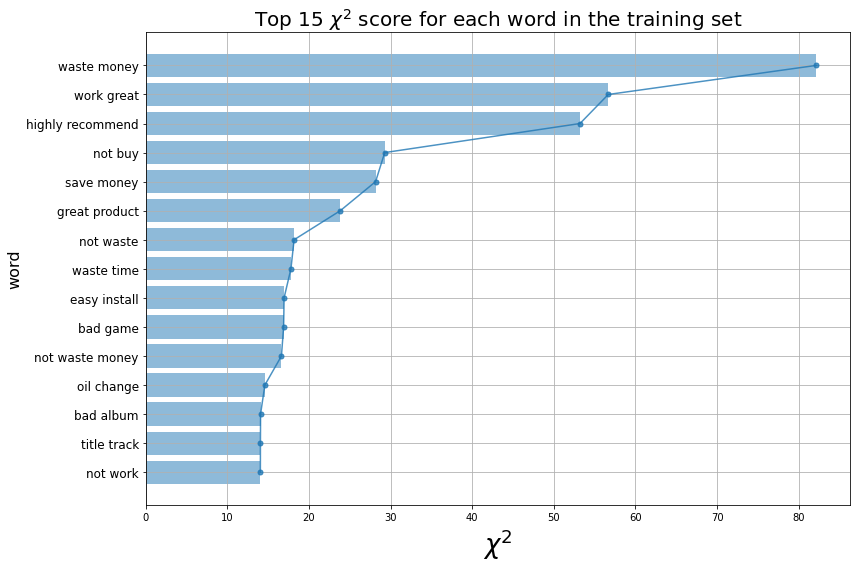

In [238]:
from sklearn.feature_selection import chi2

# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

## Palabras con el TF-IDF en alguna review

In [239]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 2901
Sentiment: pos
Review: prettiest love song everreally make feel warm fuzzy play beautiful theme music collection


In [240]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 2901:
              tfidf
make feel  0.730987
love song  0.682391

Top 10 words with lowest TF_IDF in the review 2901:
              tfidf
make feel  0.730987
love song  0.682391


## Entrenamiento modelo

In [242]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6606807826320021
Accuracy for C=0.05: 0.6633610292146878
Accuracy for C=0.25: 0.6700616456714018
Accuracy for C=0.5: 0.6719378182792817
Accuracy for C=1: 0.6794425087108014
Accuracy for C=10: 0.671133744304476
Accuracy for C=100: 0.6590726346823907


C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy for C=1000: 0.6545162154918253
Accuracy for C=10000: 0.6521039935674082


C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Varias metricas relativas al modelo de clasificación:

In [243]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[1307  559]
 [ 739 1126]]

Classification report:
              precision    recall  f1-score   support

         neg       0.64      0.70      0.67      1866
         pos       0.67      0.60      0.63      1865

    accuracy                           0.65      3731
   macro avg       0.65      0.65      0.65      3731
weighted avg       0.65      0.65      0.65      3731

Accuracy score:0.6521039935674082


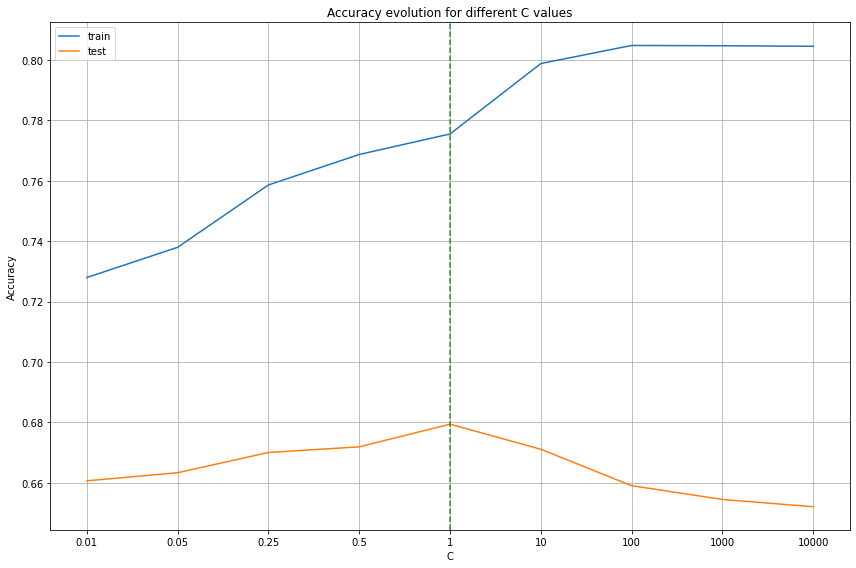

In [245]:
import numpy as np
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Una vez que hemos realizado el modelo con los diferentes valores de C, vemos como se comporta. Se observa cómo cuanto más grande es el valor de C tiende a hacer overfitting llegando el accuracy a 0.8. En el caso de test, el mejor valor lo obtiene con c=1. Ese sería el modelo con mejor performance.

Podemos ver con un ejemplo de un texto que sentimiento predice el modelo:

In [247]:
 print('Prediction: {}'.format(lr.predict(cv.transform(['Natural language processing with FastAi, LSTM and transfer learning']))))

Prediction: ['neg']


Este texto aleatorio que he obtenido de internet, no tiene pinta de ser negativo. Pero el hecho de que no sea positivo puede influir en que lo clasifique de manera negativa. En este modelo, no hemos incluido neutros que sería lo que mejor cuadraría con este texto en concreto

# NLG

## Carga de datos

In [336]:
#Accedemos a la ruta donde se han descargado los datos descargados
path = os.chdir('C:\\Users\\josu.lazaro\\Desktop\\BOOTCAMP Big Data&Machine Learning\\Bootcamp\\13.-NLP Searching\\Practica\\Datos Tweets')

In [337]:
obama = pd.read_csv('BarackObama.csv')

In [338]:
# Tenemos 6896 tweets de obama. En los proximos pasos hay que realizar limpieza de información que contienen para poder generar un generador de texto

## Preprocesado y transformación de los datos

Parseo de la informacion para eliminar los caracteres que no tienen valor, entre ellos, todo tipo de hashtag, arrobas, direcciones de correo, digitos etc.

También vamos a aplicar la limpieza de datos aplicada en otros puntos de la practica:

In [339]:
# ELiminamos abreviaturas
obama['text']=obama['text'].apply(lambda x:expand_contractions(x))

In [340]:
#Convierte todos los caracteres a minuscula
obama['cleaned']=obama['text'].apply(lambda x: x.lower())

In [341]:
#Elimina digitos y palabras que contienen digitos
obama['cleaned']=obama['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-341-91897da508bf>:2: DeprecationWarning: invalid escape sequence \w
  obama['cleaned']=obama['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))


In [342]:
obama['cleaned']=obama['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-342-616636d7e633>:1: DeprecationWarning: invalid escape sequence \w
  obama['cleaned']=obama['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))


In [343]:
##Here, string.punctuations function contains all the punctuations and we use regular expressions to search them in the text and remove them. Finally, we still have some extra spaces present in the data. Let’s remove them:
# Removing extra spaces
obama['cleaned']=obama['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [344]:
variables_selec= ["cleaned"]

obama_text=obama.loc[:,variables_selec]
obama_text.shape

(6896, 1)

In [345]:
obama_text.head()

cleaned
0  denying climate change is dangerous. join @ofa...
1  the american bar association gave judge garlan...
2  we need a fully functional supreme court. edit...
3  cynics, take note: when we #actonclimate, we b...
4  "that’s how we will overcome the challenges we...

In [346]:
import re,string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)



<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-346-d4e35fa42651>:4: DeprecationWarning: invalid escape sequence \w
  link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)


In [347]:
from html.parser import HTMLParser

obama_cleaned = []
html_parser = HTMLParser()
for index, row in obama_text.iterrows():
    if index>0:
        sentence = row[0]
        sentence = html_parser.unescape(sentence) 
        sentence = re.sub('@[A-Za-z0-9_-]+', '', sentence) 
        sentence = re.sub('([#＃]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)', '', sentence) 
        sentence = re.sub('([--:\w?@%&+~#=]*\.[a-z]{2,4}\/{0,2})((?:[?&](?:\w+)=(?:\w+))+|[--:\w?@%&+~#=]+)?', '', sentence)
        sentence = strip_all_entities(strip_links(sentence))        
        label = row[0]
        obama_cleaned.append(sentence)

<>:11: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \w
<ipython-input-347-51294fde5db4>:11: DeprecationWarning: invalid escape sequence \w
  sentence = re.sub('([--:\w?@%&+~#=]*\.[a-z]{2,4}\/{0,2})((?:[?&](?:\w+)=(?:\w+))+|[--:\w?@%&+~#=]+)?', '', sentence)
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  
C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated 

Tenemos la lista generada con los datos limpios para poder desarrollar el modelo. A continuación vemos una muestra:

In [348]:
obama_cleaned[:10]

['the american bar association gave judge garland its highest rating senate leaders and fill the',
 'we need a fully functional supreme court editorial boards across the country agree',
 'cynics take note when we we build a stronger',
 'that’s how we will overcome the challenges we face by unleashing the power of all of us for all of us read',
 'check out the most recent editorial boards calling on senate leaders to vote on judge garland',
 'senate leaders political games are handicapping the supreme court—and judgeships across the country',
 'support the bold steps we are taking against climate change say you are ready to',
 'last week more than countries reached a landmark deal to reduce carbon pollution from aviation',
 'let is leave our children and grandchildren a planet that is healthier than the one we have today',
 'climate change is effects are devastating denying the science behind it does nothing to help']

Vamos a quitar las comillas para poder separar correctamente las palabras:

In [349]:
obama_cleaned_ok=' " '.join(obama_cleaned)

Now we create a sorted set of all the unique characters that occur in the text. In a set no value appears more than once, so this is a good way to filter out the characters. After that we define two structures for converting the values. Both are dictionaries that enumerate the characters. In the first one, the characters are the keys and the indices are the values. In the second one it is the other way around. Now we can easily convert a character into a unique numerical representation and vice versa


In [384]:
characters = sorted(set(obama_cleaned_ok))
 
char_to_index = dict((c, i) for i, c in enumerate(characters))
index_to_char = dict((i, c) for i, c in enumerate(characters))
print('unique characters: {}'.format(len(characters)))

unique characters: 44


In [376]:
print(char_to_index)

{' ': 0, '"': 1, '#': 2, '@': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29, '¡': 30, '\xad': 31, 'à': 32, 'é': 33, '–': 34, '—': 35, '‘': 36, '’': 37, '“': 38, '”': 39, '․': 40, '…': 41, '√': 42, '✓': 43}


Now we create a sorted set of all the unique characters that occur in the text. In a set no value appears more than once, so this is a good way to filter out the characters. After that we define two structures for converting the values. Both are dictionaries that enumerate the characters. In the first one, the characters are the keys and the indices are the values. In the second one it is the other way around. Now we can easily convert a character into a unique numerical representation and vice versa

In [377]:
SEQ_LENGTH = 40
STEP_SIZE = 3
 
sentences = []
next_char = []

In [385]:
for i in range(0, len(obama_cleaned_ok) - SEQ_LENGTH, STEP_SIZE):
    sentences.append(obama_cleaned_ok[i: i + SEQ_LENGTH])
    next_char.append(obama_cleaned_ok[i + SEQ_LENGTH])

We iterate through the whole text and gather all sentences and their next character. This is the training data for our neural network. Now we just need to convert it into a numerical format.

In [386]:
x = np.zeros((len(sentences), SEQ_LENGTH,
              len(characters)), dtype=np.bool)
y = np.zeros((len(sentences),
              len(characters)), dtype=np.bool)
 
for i, satz in enumerate(sentences):
    for t, char in enumerate(satz):
        x[i, t, char_to_index[char]] = 1
    y[i, char_to_index[next_char[i]]] = 1

## Creación del modelo

Ahora que tenemos los datos listos para trabajar, vamos a crear una red neuronal que nos permitira crear un generador de texto


In [354]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Activation, Dense, LSTM

Vamos a usar un modo secuencial para el modelo, con capas Densas y LSTM y RMSProp para la optimización del error durante la compilación. LSTM es un tipo de capa de red neuronal recurrente.

In [366]:
model = Sequential()
model.add(LSTM(128,
               input_shape=(SEQ_LENGTH,
                            len(characters))))
model.add(Dense(len(characters)))
model.add(Activation('softmax'))

Hemos creado una estructura simple. La primera capa LSTM con 128 neuronas de entrada con una entrada equivalente al numero de caracteres unicos que tiene el texto origen. Agregamos una capa densa para incrementar la complejidad y la función de activación va a ser SoftMax. Esta función nos va a dar la probabilidad de cada caracter.

In [395]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),metrics=['accuracy'])
 
modelo_history = model.fit(x, y, batch_size=128,validation_split=0.05, epochs=10,verbose=1,shuffle=True).history

#modelo = model.fit(x, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 197842 samples, validate on 10413 samples
Epoch 1/10
197842/197842 [==============================] - 281s 1ms/sample - loss: 1.0134 - acc: 0.6925 - val_loss: 1.6719 - val_acc: 0.5401
Epoch 2/10
197842/197842 [==============================] - 298s 2ms/sample - loss: 0.9750 - acc: 0.7039 - val_loss: 1.6737 - val_acc: 0.5412
Epoch 3/10
197842/197842 [==============================] - 287s 1ms/sample - loss: 0.9569 - acc: 0.7097 - val_loss: 1.6940 - val_acc: 0.5376
Epoch 4/10
197842/197842 [==============================] - 286s 1ms/sample - loss: 0.9431 - acc: 0.7145 - val_loss: 1.7006 - val_acc: 0.5408
Epoch 5/10
197842/197842 [==============================] - 297s 1ms/sample - loss: 0.9316 - acc: 0.7175 - val_loss: 1.7258 - val_acc: 0.5363
Epoch 6/10
197842/197842 [==============================] - 295s 1ms/sample - loss: 0.9220 - acc: 0.7206 - val_loss: 1.7319 - val_acc: 0.5365
Epoch 7/10
197842/197842 [==============================] - 298s 2ms/sample - loss: 0.9128 - acc:

Una vez compilado el modelo, visualizamos los resultados en train y test del accuracy del mismo:

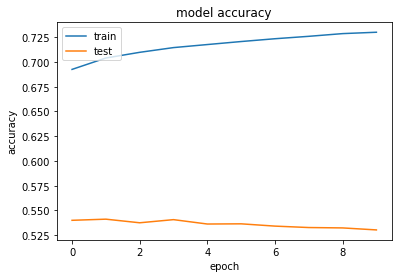

In [396]:
# Model accuracy
plt.plot(modelo_history['acc'])
plt.plot(modelo_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

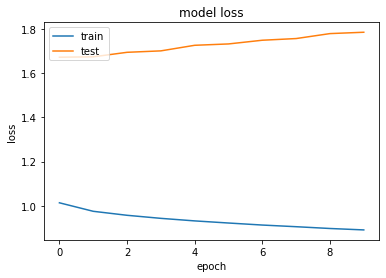

In [397]:
# Model loss
plt.plot(modelo_history['loss'])
plt.plot(modelo_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Podemos observar que el modelo en train tiende a realizar overfitting a medida que se van acumulando epocas y sin embargo el test tiene un accuracy menor. Para solucionar este tipo de problemas, tendríamos que hacer muchas más pruebas, en la arquitectura, modificando la estructura de capas, los parametros de la red e ir viendo resultados. Este modelo es una aproximación a lo que debería ser el resultado final, pero los tiempos de ejecución no permiten realizar muchas ejecuciones.

### Generamos texto y testeamos el modelo


Básicamente, solo elige uno de los caracteres de la salida. Como parámetros toma el resultado de la predicción y una temperatura. Esta temperatura indica lo arriesgado que será el pico. Si tenemos una temperatura alta, elegiremos uno de los caracteres menos probables. Una temperatura baja causará una elección conservadora.

In [398]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Básicamente, elegimos una posición inicial aleatoria dentro del texto porque necesitamos algo de texto inicial para predecir el carácter "siguiente". La primera cantidad de caracteres SEQ_LENGTH se copiará del texto original. Pero podríamos cortarlos luego y terminaríamos con un texto que es completamente generado por nuestra red neuronal.

In [399]:
def generate_text(text,length, temperature):
    start_index = random.randint(0, len(text) - SEQ_LENGTH - 1)
    generated = ''
    sentence = text[start_index: start_index + SEQ_LENGTH]
    generated += sentence
    for i in range(length):
        x_predictions = np.zeros((1, SEQ_LENGTH, len(characters)))
        for t, char in enumerate(sentence):
            x_predictions[0, t, char_to_index[char]] = 1

        predictions = model.predict(x_predictions, verbose=0)[0]
        next_index = sample(predictions,
                                 temperature)
        next_character = index_to_char[next_index]

        generated += next_character
        sentence = sentence[1:] + next_character
    return generated

In [402]:
print(generate_text(obama_cleaned_ok,300, 0.2))

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


etter every day " not voting “could be the american people are not the state of the first time to senate leaders are not be a strong a woman is the president is a moving forward in the world " if you are ready to action to go up for the president is a movement is that we can we can’t afford to senate leaders to stand with the president is


In [403]:
print(generate_text(obama_cleaned_ok,300, 0.4))

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ought for america ought to have a home in a strong because we work that is a fair shates and women are not back to the president is president obama is start of the american people are president is still believe that how women who are good —president obama " we are how the first time to pay for the world was the " the president is first la


In [404]:
print(generate_text(obama_cleaned_ok,300, 0.8))

C:\Users\josu.lazaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


er " a map showing romney’s record of our ware up and congress on the economy added jobs in a progress to congress to pay for children and check it hapre how let is always dia have be the to keep look of the millions of americans build a vote it is time to uneichad because obamacare in a friend up elix my just for the same " speaking to t


Elegimos un texto inicial aleatorio y luego ejecutamos un bucle for en el rango de la longitud que queremos. Podemos generar un texto con 100 caracteres o uno con 20,000. Luego convertimos nuestra frase al formato de entrada deseado del que ya hablamos. La frase ahora es una matriz con unos o Trues.
Luego usamos el método de predicción de nuestro modelo, para predecir las probabilidades de los siguientes caracteres. 

Posteriormente, hacemos uso de nuestra función auxiliar SAMPLE. En esta función también tenemos un parámetro de temperatura, que podemos pasar a esa función auxiliar. El resultado obtenido debe convertirse de formato numérico a caracter, agregamos el caracter al texto y se itera el proceso hasta alcanzar la longitud deseada de generación.